#RosettaScript DDG Backrub Protocol - First Iteration
##MC Trials = 1000, kT = 1.6, nstruct 10

This is the semi-worked up data for my first semi-complete run of my RosettaScript DDG Backrub Protocol on the full Zemu dataset (1240 points). Outlier data points where -10 < df.Predicted < 10 were set to upper/lower bound values and included in the analysis (~100 points).<br>

###Plot_all Function
The plot_all function creates three plots:<br>
* sns.regplot with regressions for all data points, only WT to ALA mutants, and WT to all else mutants. The slope, intercept, r-value, p-value, and stdder values are stored within the regression_data DataFrame. (Title = RosettaScripts Backrub Protocol (Trials = 1000, kT = 1.6))
* sns.jointplt with marginal histograms to show distribution of Experimental_ZEMu vs. Predicted for all data points 
* sns.jointplt with marginal histograms to show distribution of Experimental_ZEMu vs. Predicted for only WT to ALA mutants

###Plot_X_to_A Function
The plot_X_to_A function creates individual plots using sns.lmplot to show Experimental_ZEMu vs. Predicted regressions for each WildTypeAA where MutantAA = ALA. The regression slope, intercept, r-value, p-value, and stdder values are stored within the regression_data DataFrame.

##Meeting with Tanja: April 4, 2016

###Suggestions:
* Look up minimization with constraints..
* Parse my tag + minimize with constraint

###To do:
* Mutate step repack with soft repulsive (find soft version of talaris)
* Add 1+/1- for pivot resdiues in backrub mover
* Figure out difference between backrub mover and protocol
* Less trials, more structures
* Get backbone RMSD's and compare to WT structures
* Make BackrunProtocol Mover for RosettaScripts
* Minimize w/ constraints Mover vs. Application and get RMSD's

/Users/jameslucas/Kortemme_Rotation/DDG_CODE/jameslucas

df10 Data Set Stats
             Slope  Intercept       R^2       P-value  Std. Error         R
All data  0.512521   0.206098  0.243675  8.154829e-18    0.058692  0.493634
Only ALA  0.556529   0.022487  0.261400  8.923679e-16    0.067973  0.511273
Not ALA   0.464437   0.648958  0.223119  1.142514e-04    0.118744  0.472355

Wildtype to ALA mutations - df10 Data Set
      Slope  Intercept       R^2   P-value  Std. Error  Counts         R
C -0.987884   0.838224 -0.989642  0.001263    0.082735       6       NaN
D  0.716804  -0.252836  0.403873  0.001374    0.213194      77  0.635510
E  0.844701   0.504921  0.381443  0.001030    0.246437      94  0.617610
F  0.319915   0.880466  0.112315  0.547471    0.525582      36  0.335135
H  0.761106   0.471331  0.320832  0.135532    0.490309      33  0.566421
I -0.271324   1.036907 -0.120962  0.475749    0.376361      48       NaN
K  0.056411   1.028704  0.022693  0.847811    0.292885      97  0

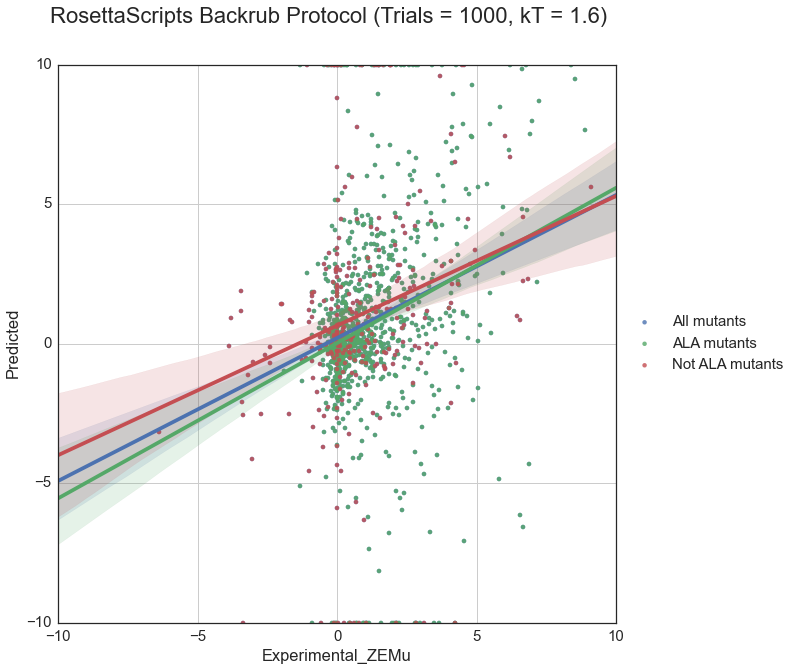

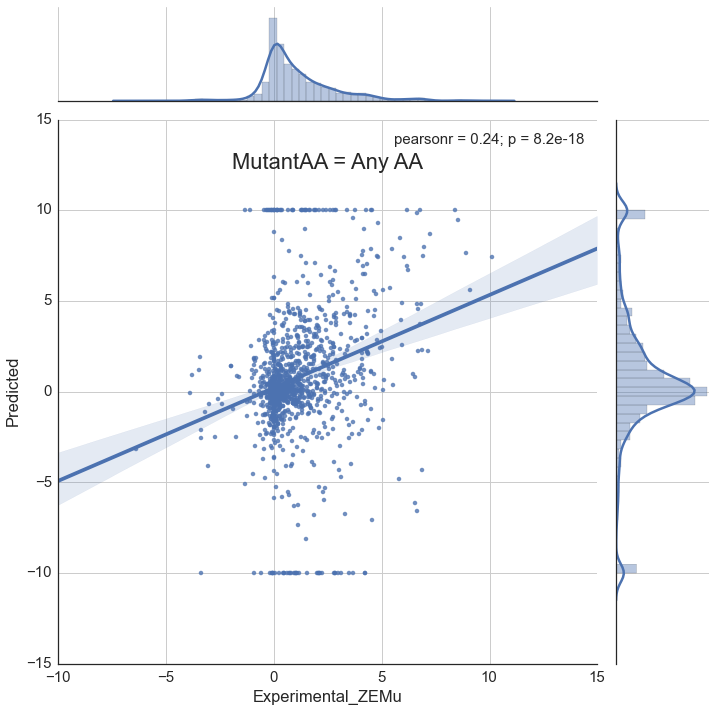

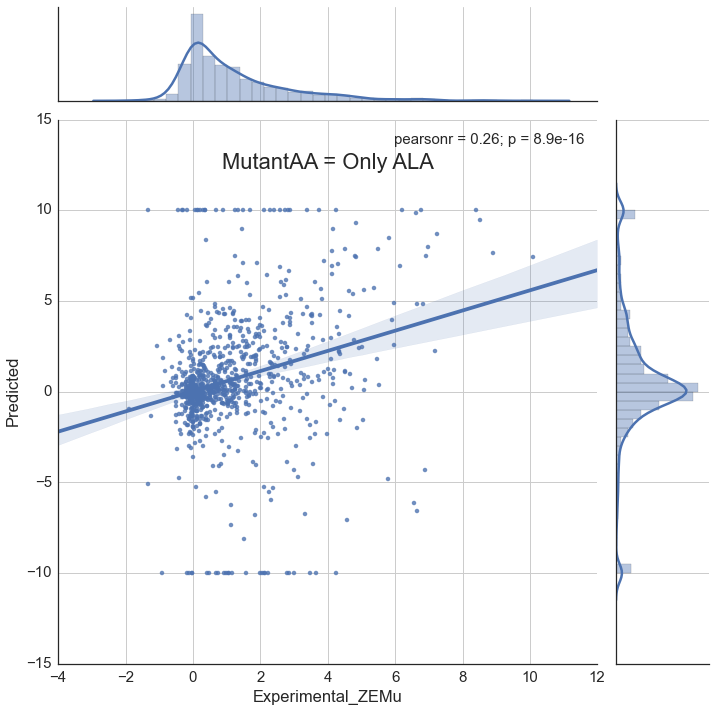

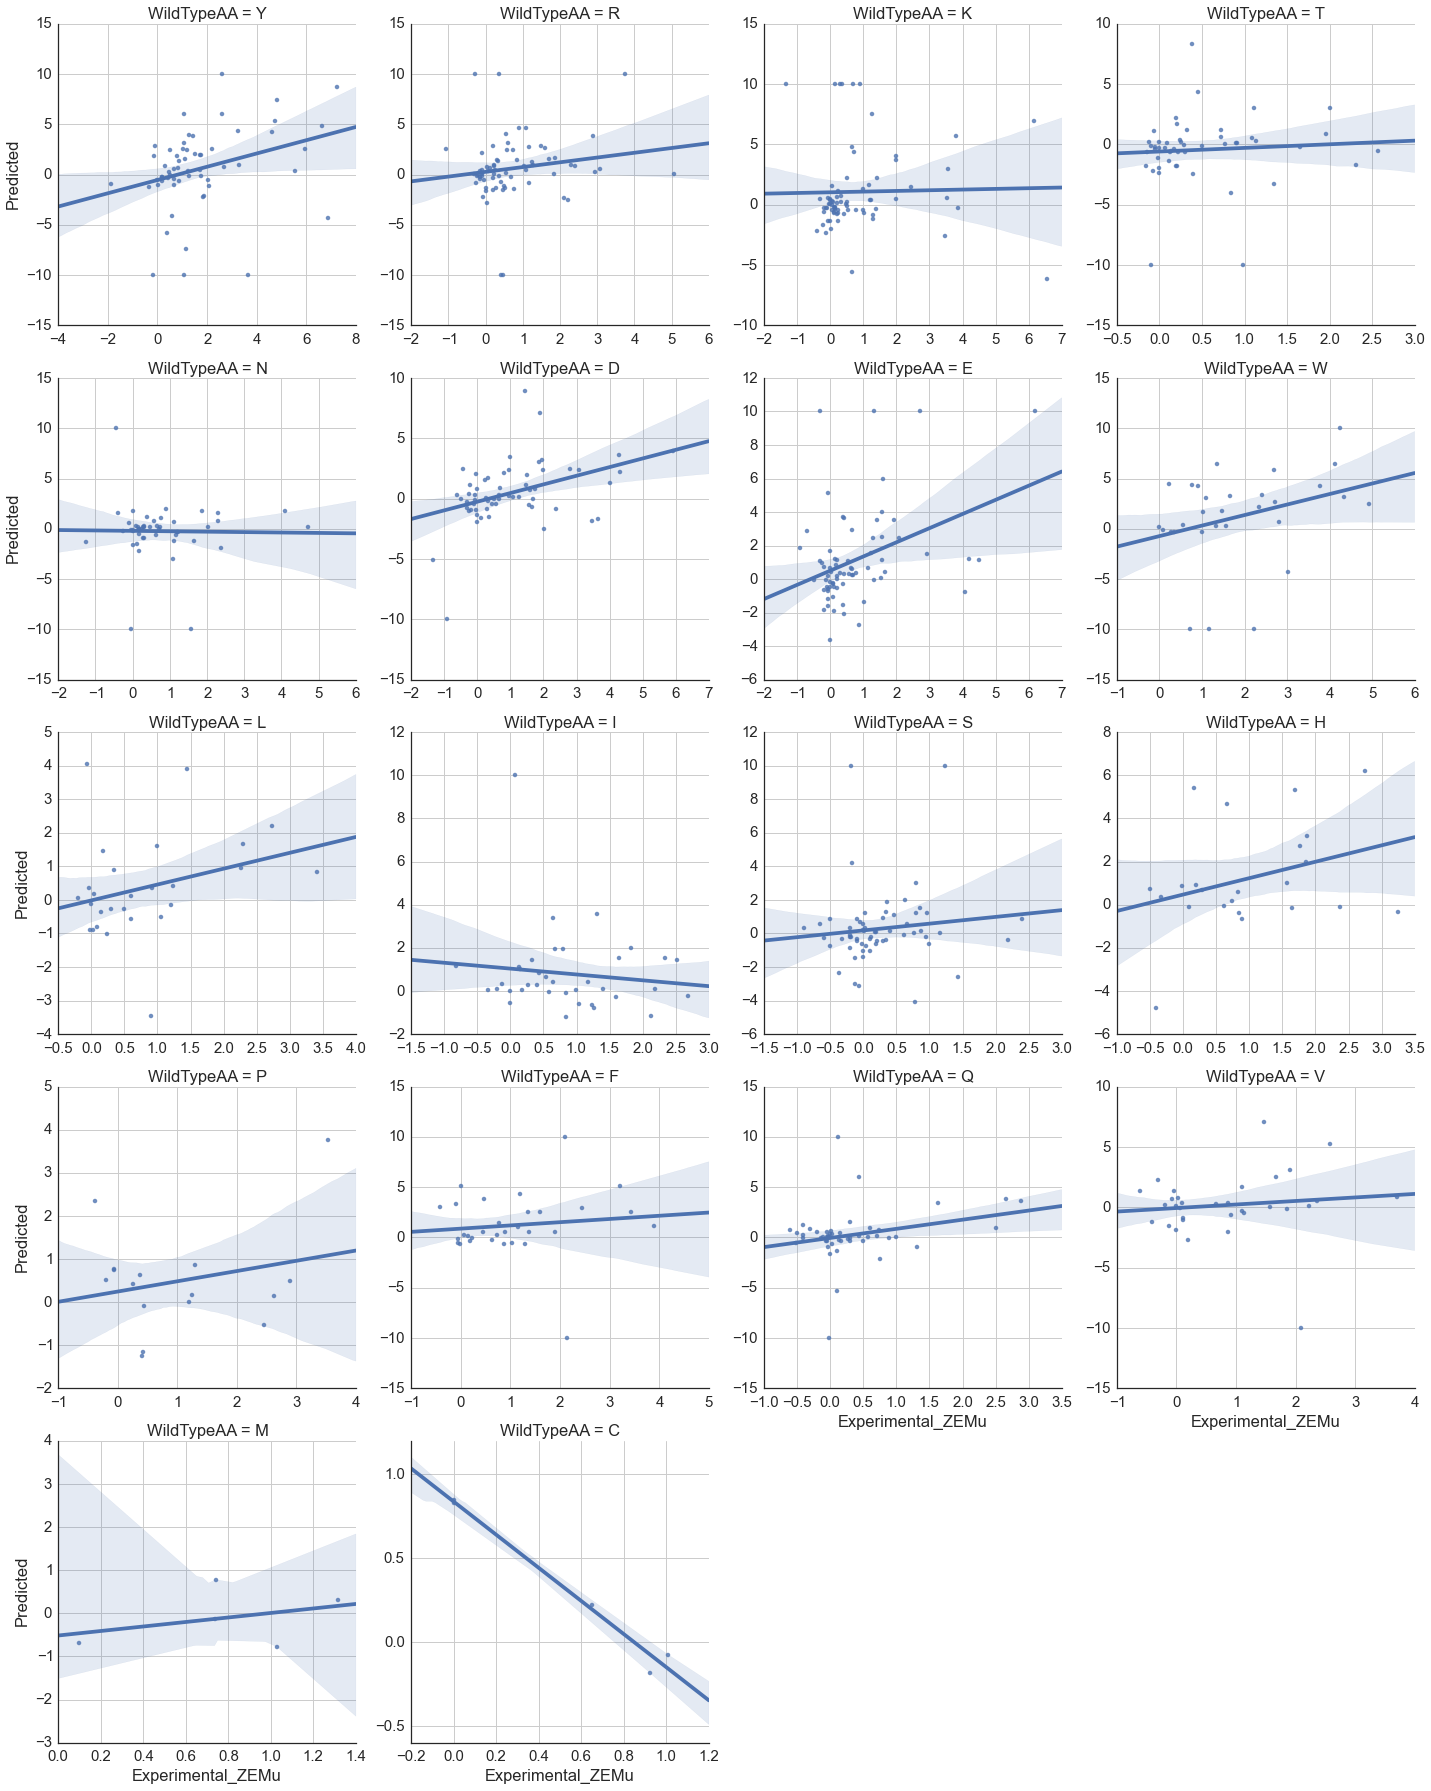

In [67]:
import pandas as pd
import matplotlib
import scipy as sp
import matplotlib.gridspec as gs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

#Removes/adjusts crazy outliers in dataset
##Removes outliers 10 > x > -10 
#df3 = pd.read_csv("/Users/jameslucas/Kortemme_Rotation/multiple_analysis/topx_3-data.csv")
#df3 = df3[df3.Predicted < 10]
#df3 = df3[df3.Predicted > -10]

#Sets outliers to upper/lower bounds
df10 = pd.read_csv("/Users/jameslucas/Kortemme_Rotation/multiple_analysis/topx_10-data.csv")
for i, j in df10.iterrows():
    if j['Predicted'] > 10:
        df10.loc[i, 'Predicted'] =10
    elif j['Predicted'] < -10:
        df10.loc[i, 'Predicted'] = -10
    else:
        continue
        
#df10 = df10[df10.Predicted < 10]
#df10 = df10[df10.Predicted > -10]

df10.to_csv('TEST.csv')
print os.getcwd()

def plot_X_to_A(df):    
    #Parse df for instances where MutantAA == 'A'
    df_MutA = pd.DataFrame()
    df_MutX = pd.DataFrame()
    for index, data in df.iterrows():
        if data['MutantAA'] == 'A':
            df_MutA = df_MutA.append(data)
        else:
            df_MutX = df_MutX.append(data)
    
    #Performs linear regressions for all ALA mutants for each WildTypeAA
    lm = sns.lmplot('Experimental_ZEMu',
                    'Predicted',
                    df_MutA, 
                    col = 'WildTypeAA',
                    col_wrap = 4,
                    sharex=False,
                    sharey=False
                   )
    axes = lm.axes
    
    sns.husl_palette(n_colors = 3, h = 5)
    sns.set_style("white", {'axes.grid': True})
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.despine()
    
    #Performs and saves regressions
    regression_data = pd.DataFrame(columns=('Slope', 'Intercept', 'R^2', 'P-value', 'Std. Error'))
    for AA in df_MutA.groupby('WildTypeAA'):
        slope, intercept, r_value, p_value, stderr = sp.stats.linregress(AA[1]['Experimental_ZEMu'], AA[1]['Predicted'])
        regression_data = regression_data.append(pd.Series([slope, intercept, r_value, p_value, stderr],
                                         index = ['Slope', 'Intercept', 'R^2', 'P-value', 'Std. Error'],
                                         name = AA[0]))
        
    counts = df.groupby('WildTypeAA').size()
    counts.name = 'Counts'
    regression_data =  regression_data.join(counts)
    
    #Converts R**2 to R and appends to DataFrame
    R = pd.Series(name = 'R')
    for i,j in regression_data.iterrows():
        R = R.append(pd.Series([j['R^2'] ** 0.5], index = [i]))
    R.name = 'R'
    regression_data = pd.concat([regression_data, R], axis = 1)
    
    print regression_data
    
def plot_all(df):    
    #Parse df for instances where MutantAA == 'A'
    df_MutA = pd.DataFrame()
    df_MutX = pd.DataFrame()
    for index, data in df.iterrows():
        if data['MutantAA'] == 'A':
            df_MutA = df_MutA.append(data)
        else:
            df_MutX = df_MutX.append(data)
    
    #Single plot for MutantAA == 'A'
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax = sns.regplot(df.Experimental_ZEMu, df.Predicted, df_MutX, label = 'All mutants')
    ax = sns.regplot(df_MutA.Experimental_ZEMu, df_MutA.Predicted, df_MutA, label = 'ALA mutants')
    ax = sns.regplot(df_MutX.Experimental_ZEMu, df_MutX.Predicted, df_MutX, label = 'Not ALA mutants')
    
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1,0.5))
    title = fig.suptitle("RosettaScripts Backrub Protocol (Trials = 1000, kT = 1.6)", fontsize = 22)
    
    #Shows distributions of data points
    sns.jointplot('Experimental_ZEMu', 'Predicted', data = df, kind = 'reg', size = 10)
    title = plt.title("MutantAA = Any AA", y = 0.9, fontsize = 22)
    
    sns.jointplot('Experimental_ZEMu', 'Predicted', data = df_MutA, kind = 'reg', size = 10)
    title = plt.title("MutantAA = Only ALA", y = 0.9, fontsize = 22)
    
    sns.set_style("white", {'axes.grid': True})
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.despine()
    
    #Performs and saves regressions
    regression_data = pd.DataFrame(columns=('Slope', 'Intercept', 'R^2', 'P-value', 'Std. Error'))
    
    slope, intercept, r_value, p_value, stderr = sp.stats.linregress(df.Experimental_ZEMu, df.Predicted)
    regression_data = regression_data.append(pd.Series([slope, intercept, r_value, p_value, stderr], 
                                                       index = ['Slope', 'Intercept', 'R^2', 'P-value', 'Std. Error'], 
                                                       name = 'All data'))
    slope, intercept, r_value, p_value, stderr = sp.stats.linregress(df_MutA.Experimental_ZEMu, df_MutA.Predicted)
    regression_data = regression_data.append(pd.Series([slope, intercept, r_value, p_value, stderr], 
                                                       index = ['Slope', 'Intercept', 'R^2', 'P-value', 'Std. Error'], 
                                                       name = 'Only ALA'))
    slope, intercept, r_value, p_value, stderr = sp.stats.linregress(df_MutX.Experimental_ZEMu, df_MutX.Predicted)
    regression_data = regression_data.append(pd.Series([slope, intercept, r_value, p_value, stderr], 
                                                       index = ['Slope', 'Intercept', 'R^2', 'P-value', 'Std. Error'], 
                                                       name = 'Not ALA'))
    
    #Converts R**2 to R and appends to DataFrame
    R = pd.Series(name = 'R')
    for i,j in regression_data.iterrows():
        R = R.append(pd.Series([j['R^2'] ** 0.5], index = [i]))
    R.name = 'R'
    regression_data = pd.concat([regression_data, R], axis = 1)
    
    print regression_data

print "\ndf10 Data Set Stats"
plot_all(df10)

print "\nWildtype to ALA mutations - df10 Data Set"
plot_X_to_A(df10)

#print "\ndf3 Data Set"
#plot_all(df3)

#print "\nWildtype to ALA mutations - df3 Data Set"
#plot_X_to_A(df3)